In [8]:
!pip3 install -r requirements.txt


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [4]:
import os, glob, subprocess
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import torchaudio
import torchaudio.transforms as T
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [5]:
# ------------------------------
# SETTINGS
# ------------------------------
RAW_VIDEOS = "raw_videos/battery"
AUDIO_DIR = "audio_segments/battery"
IMAGE_DIR = "recorded_images/battery"
SAMPLE_RATE = 44100
N_MELS = 64
CHUNK_SECONDS = 2
BATCH_SIZE = 8
EPOCHS = 15
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

label_map = {"full": 0, "half": 1, "empty": 2}
LABELS = {v: k.capitalize() for k, v in label_map.items()}

os.makedirs(AUDIO_DIR, exist_ok=True)
os.makedirs(IMAGE_DIR, exist_ok=True)

In [6]:
# ------------------------------
# PREPROCESSING
# ------------------------------
def extract_audio(video_path, audio_out, sample_rate=SAMPLE_RATE, max_duration=90):
    cmd = ["ffmpeg", "-y", "-i", video_path, "-t", str(max_duration),
           "-ar", str(sample_rate), "-ac", "1", audio_out]
    subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, check=True)

def extract_frame(video_path, image_out, timestamp=2.0):
    cmd = ["ffmpeg", "-y", "-i", video_path, "-ss", str(timestamp), "-vframes", "1", image_out]
    subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, check=True)

def split_audio_and_frames(video_path, audio_out_dir, image_out_dir,
                           chunk_sec=CHUNK_SECONDS, sample_rate=SAMPLE_RATE):
    base = os.path.splitext(os.path.basename(video_path))[0]
    audio_tmp = os.path.join(audio_out_dir, base + ".wav")
    extract_audio(video_path, audio_tmp, sample_rate=sample_rate)

    waveform, sr = torchaudio.load(audio_tmp)
    if sr != sample_rate:
        waveform = torchaudio.functional.resample(waveform, sr, sample_rate)
    total_samples = waveform.shape[1]
    chunk_samples = chunk_sec * sample_rate

    for i, start in enumerate(range(0, total_samples, chunk_samples)):
        end = min(start + chunk_samples, total_samples)
        seg_waveform = waveform[:, start:end]
        seg_name = f"{base}_seg{i}.wav"
        seg_path = os.path.join(audio_out_dir, seg_name)
        torchaudio.save(seg_path, seg_waveform, sample_rate)

        timestamp = i * chunk_sec
        frame_path = os.path.join(image_out_dir, f"{base}_frame{i}.jpg")
        extract_frame(video_path, frame_path, timestamp=timestamp)

    print(f"[INFO] Processed {video_path} → {i+1} chunks")

def prepare_dataset(raw_videos, audio_dir, image_dir):
    video_files = glob.glob(os.path.join(raw_videos, "*.MOV")) + glob.glob(os.path.join(raw_videos, "*.mp4"))
    for vf in video_files:
        split_audio_and_frames(vf, audio_dir, image_dir)
    print(f"[INFO] Finished preprocessing {len(video_files)} videos.")

In [7]:
# ------------------------------
# IMAGE TRANSFORM
# ------------------------------
gray = transforms.Grayscale(num_output_channels=3)
transform_image = transforms.Compose([
    transforms.Resize((224,224)),
    gray,
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])


class AudioImageDataset(Dataset):
    def __init__(self, audio_dir, image_dir, label_map, transform_image=None):
        self.audio_dir = audio_dir
        self.image_dir = image_dir
        self.label_map = label_map
        self.audio_files, self.labels, self.video_ids = [], [], []

        for file in os.listdir(audio_dir):
            if file.endswith(".wav") and "_seg" in file:
                base_name = file.split("_seg")[0]
                label_str = base_name.split("_")[0].lower()
                if label_str in label_map:
                    self.audio_files.append(file)
                    self.labels.append(label_map[label_str])
                    self.video_ids.append(base_name)

        self.transform_image = transform_image
        self.sample_rate = SAMPLE_RATE
        self.mel = T.MelSpectrogram(sample_rate=self.sample_rate, n_fft=1024,
                                    hop_length=512, n_mels=N_MELS)
        self.db = T.AmplitudeToDB()

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        audio_file = self.audio_files[idx]
        audio_path = os.path.join(self.audio_dir, audio_file)

        waveform, sr = torchaudio.load(audio_path)
        if sr != self.sample_rate:
            waveform = torchaudio.functional.resample(waveform, sr, self.sample_rate)
        spec = self.mel(waveform)
        spec = self.db(spec)
        spec = (spec - spec.mean()) / (spec.std() + 1e-6)
        spec = F.interpolate(spec.unsqueeze(0), size=(224,224), mode="bilinear", align_corners=False)
        spec = spec.mean(dim=1)  # [1,224,224]

        frame_file = audio_file.replace("seg", "frame").replace(".wav", ".jpg")
        img_path = os.path.join(self.image_dir, frame_file)
        img = Image.open(img_path).convert("RGB")
        if self.transform_image:
            img = self.transform_image(img)

        label = self.labels[idx]
        video_id = self.video_ids[idx]
        return spec, img, label, video_id



In [8]:
# ------------------------------
# MODEL
# ------------------------------
class MultiModalResNet(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.audio_model = models.resnet18(pretrained=True)
        self.audio_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.audio_model.fc = nn.Identity()
        self.image_model = models.resnet18(pretrained=True)
        self.image_model.fc = nn.Identity()
        self.fc = nn.Linear(512*2, num_classes)

    def forward(self, audio, image, return_features=False):
        a = self.audio_model(audio)
        i = self.image_model(image)
        fused = torch.cat([a, i], dim=1)
        out = self.fc(fused)
        if return_features:
            return a, i, fused, out
        return out

In [9]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch

def visualize_features(model, dataloader, title_suffix=""):
    model.eval()
    audio_feats, image_feats, fused_feats, labels_all = [], [], [], []

    with torch.no_grad():
        for audio, img, labels, _ in dataloader:
            audio, img, labels = audio.to(DEVICE), img.to(DEVICE), labels.to(DEVICE)
            # Get features from both branches
            a, i, fused, _ = model(audio, img, return_features=True)
            audio_feats.append(a.cpu())
            image_feats.append(i.cpu())
            fused_feats.append(fused.cpu())
            labels_all.append(labels.cpu())

    # Stack into numpy
    audio_feats = torch.cat(audio_feats).numpy()
    image_feats = torch.cat(image_feats).numpy()
    fused_feats = torch.cat(fused_feats).numpy()
    labels_all = torch.cat(labels_all).numpy()

    # Pick safe perplexity
    n_samples = fused_feats.shape[0]
    perplexity = min(30, max(2, n_samples // 3))

    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)

    audio_2d = tsne.fit_transform(audio_feats)
    image_2d = tsne.fit_transform(image_feats)
    fused_2d = tsne.fit_transform(fused_feats)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    for feat, name, ax in zip([audio_2d, image_2d, fused_2d],
                              ["Audio Features", "Image Features", "Fused Features"],
                              axes):
        for l in set(labels_all):
            idxs = labels_all == l
            ax.scatter(feat[idxs, 0], feat[idxs, 1],
                       label=LABELS[l], alpha=0.6, s=20)
        ax.set_title(f"{name} {title_suffix}")
        ax.legend()

    plt.tight_layout()
    plt.show()


In [10]:
# ------------------------------
# TRAINING
# ------------------------------
def train():
    dataset = AudioImageDataset(audio_dir=AUDIO_DIR, image_dir=IMAGE_DIR,
                                label_map=label_map, transform_image=transform_image)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    model = MultiModalResNet(num_classes=len(label_map)).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(EPOCHS):
        # TRAIN
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for audio, img, labels, video_ids in train_loader:
            audio, img, labels = audio.to(DEVICE), img.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(audio, img)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * audio.size(0)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        # VALIDATION
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        val_preds, val_labels, val_video_ids = [], [], []

        with torch.no_grad():
            for audio, img, labels, video_ids in val_loader:
                audio, img, labels = audio.to(DEVICE), img.to(DEVICE), labels.to(DEVICE)
                outputs = model(audio, img)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * audio.size(0)
                _, preds = outputs.max(1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

                val_preds.extend(preds.cpu().tolist())
                val_labels.extend(labels.cpu().tolist())
                val_video_ids.extend(video_ids)

        val_loss /= val_total
        val_acc = val_correct / val_total

        print(f"Epoch [{epoch+1}/{EPOCHS}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # VIDEO-LEVEL ACCURACY
        video_level = {}
        for vid, lab, pred in zip(val_video_ids, val_labels, val_preds):
            if vid not in video_level:
                video_level[vid] = {"labels": [], "preds": []}
            video_level[vid]["labels"].append(lab)
            video_level[vid]["preds"].append(pred)

        video_correct, video_total = 0, 0
        for vid, d in video_level.items():
            final_pred = max(set(d["preds"]), key=d["preds"].count)
            true_label = d["labels"][0]
            if final_pred == true_label:
                video_correct += 1
            video_total += 1

        if video_total > 0:
            video_acc = video_correct / video_total
            print(f"Val Video-Level Accuracy: {video_acc:.4f}")

        if (epoch+1) % 5 == 0:   # every 5 epochs
            visualize_features(model, val_loader, title_suffix=f"(Epoch {epoch+1})")


    torch.save(model.state_dict(), "multimodal_model_battery_v2.pth")
    print("Training complete and model saved!")

/Users/shamit/Documents/Projects/RA/cobas/cobas/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/shamit/Documents/Projects/RA/cobas/cobas/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/shamit/Documents/Projects/RA/cobas/cobas/venv/lib/python3.9/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer

Epoch [1/15] Train Loss: 0.1618, Train Acc: 0.9444, Val Loss: 0.0297, Val Acc: 1.0000
Val Video-Level Accuracy: 1.0000
Epoch [2/15] Train Loss: 0.0276, Train Acc: 0.9957, Val Loss: 0.0012, Val Acc: 1.0000
Val Video-Level Accuracy: 1.0000
Epoch [3/15] Train Loss: 0.0268, Train Acc: 0.9915, Val Loss: 0.0018, Val Acc: 1.0000
Val Video-Level Accuracy: 1.0000
Epoch [4/15] Train Loss: 0.0178, Train Acc: 1.0000, Val Loss: 0.0005, Val Acc: 1.0000
Val Video-Level Accuracy: 1.0000
Epoch [5/15] Train Loss: 0.0059, Train Acc: 1.0000, Val Loss: 0.0004, Val Acc: 1.0000
Val Video-Level Accuracy: 1.0000


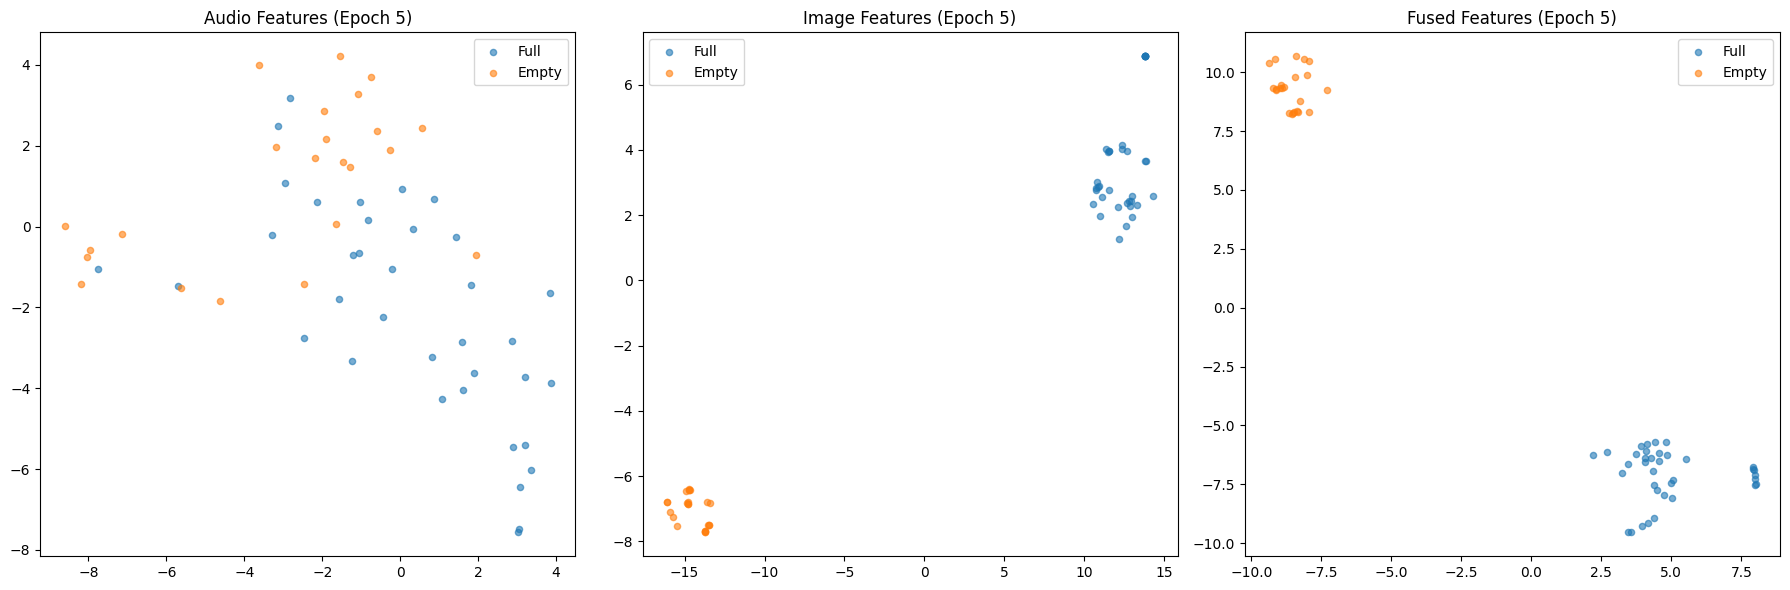

/Users/shamit/Documents/Projects/RA/cobas/cobas/venv/lib/python3.9/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


Epoch [6/15] Train Loss: 0.0448, Train Acc: 0.9872, Val Loss: 0.0021, Val Acc: 1.0000
Val Video-Level Accuracy: 1.0000
Epoch [7/15] Train Loss: 0.0137, Train Acc: 0.9957, Val Loss: 0.0019, Val Acc: 1.0000
Val Video-Level Accuracy: 1.0000
Epoch [8/15] Train Loss: 0.0195, Train Acc: 1.0000, Val Loss: 0.0007, Val Acc: 1.0000
Val Video-Level Accuracy: 1.0000
Epoch [9/15] Train Loss: 0.0206, Train Acc: 0.9957, Val Loss: 0.0006, Val Acc: 1.0000
Val Video-Level Accuracy: 1.0000
Epoch [10/15] Train Loss: 0.0559, Train Acc: 0.9872, Val Loss: 0.0030, Val Acc: 1.0000
Val Video-Level Accuracy: 1.0000


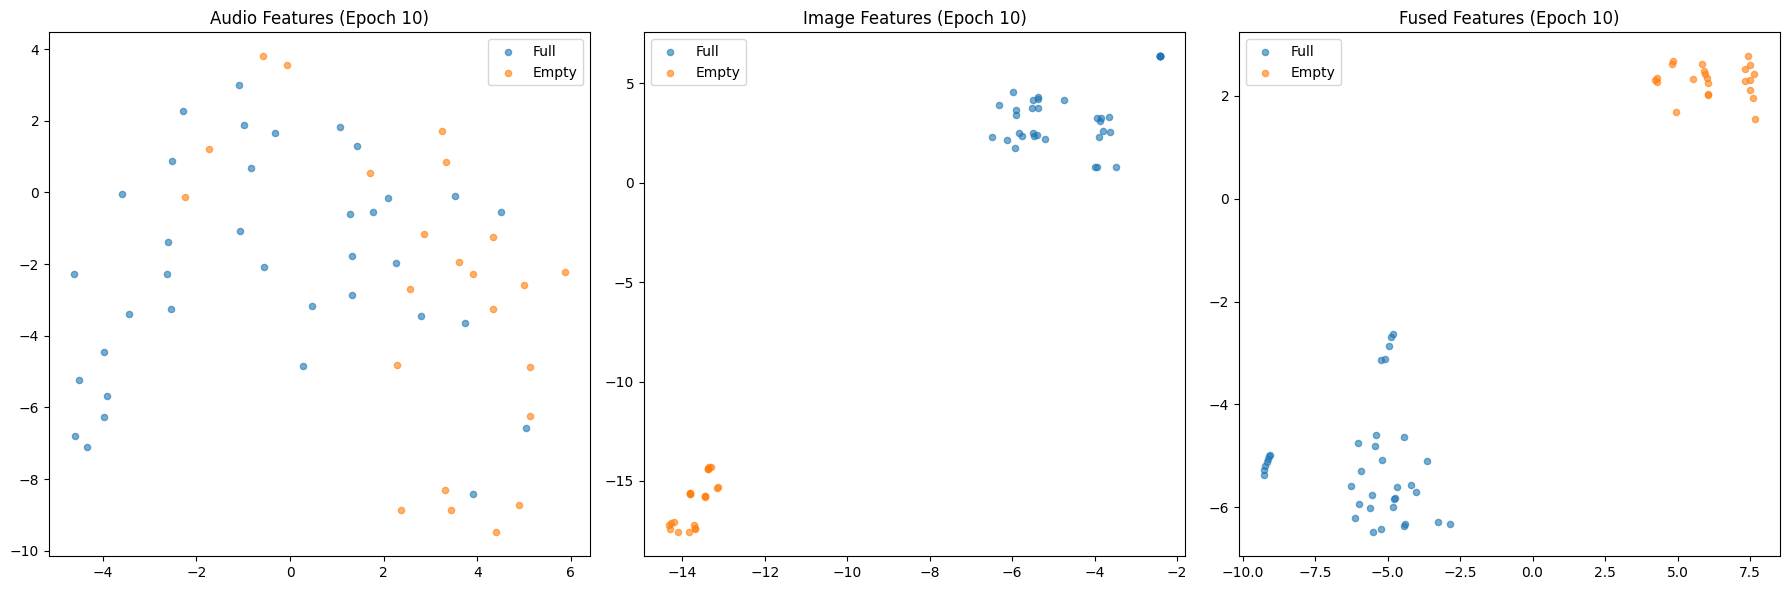

/Users/shamit/Documents/Projects/RA/cobas/cobas/venv/lib/python3.9/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


Epoch [11/15] Train Loss: 0.0062, Train Acc: 1.0000, Val Loss: 0.0003, Val Acc: 1.0000
Val Video-Level Accuracy: 1.0000
Epoch [12/15] Train Loss: 0.0086, Train Acc: 0.9957, Val Loss: 0.0002, Val Acc: 1.0000
Val Video-Level Accuracy: 1.0000
Epoch [13/15] Train Loss: 0.0052, Train Acc: 1.0000, Val Loss: 0.0002, Val Acc: 1.0000
Val Video-Level Accuracy: 1.0000
Epoch [14/15] Train Loss: 0.0186, Train Acc: 0.9915, Val Loss: 0.0004, Val Acc: 1.0000
Val Video-Level Accuracy: 1.0000
Epoch [15/15] Train Loss: 0.0348, Train Acc: 0.9872, Val Loss: 0.0008, Val Acc: 1.0000
Val Video-Level Accuracy: 1.0000


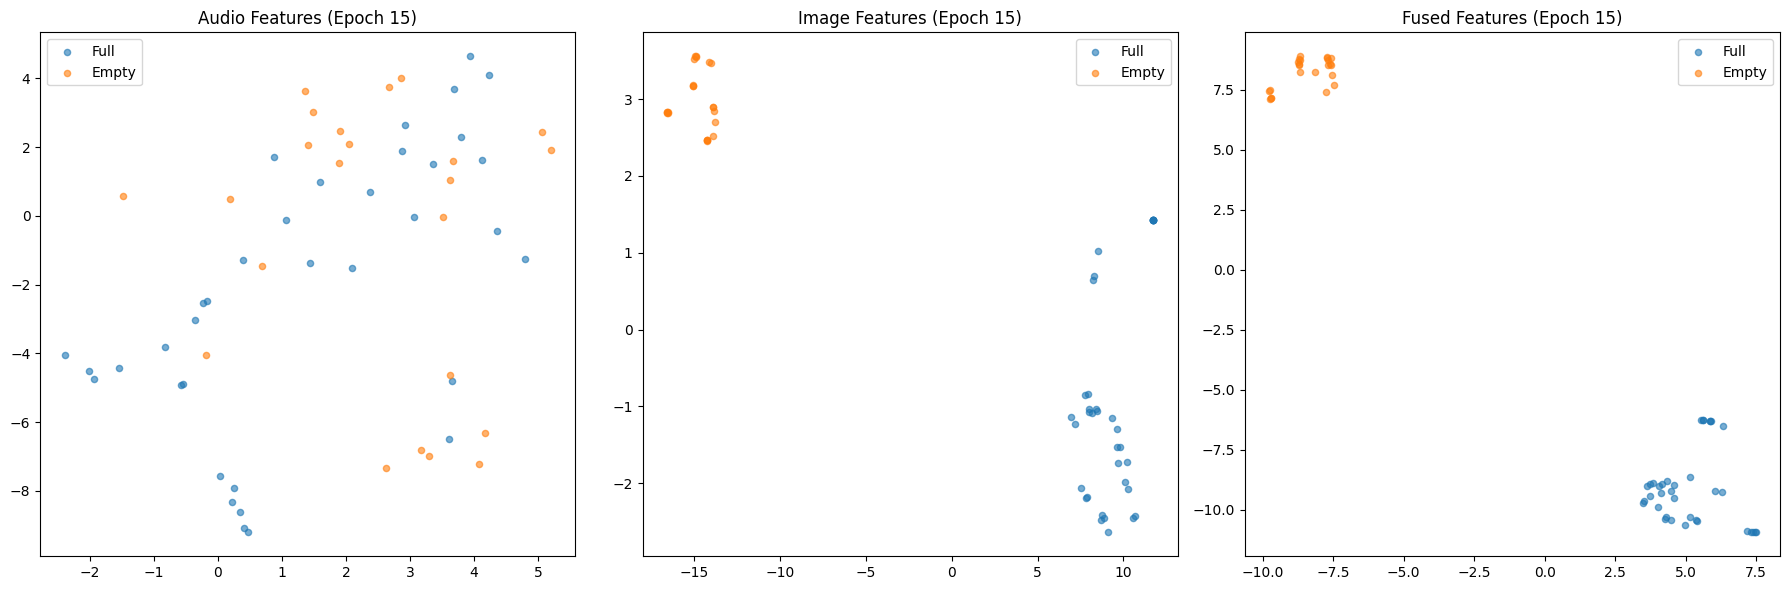

Training complete and model saved!


In [11]:
# ------------------------------
# MAIN
# ------------------------------
if __name__ == "__main__":
    # Preprocess raw videos once (comment out if already processed)
    # prepare_dataset(RAW_VIDEOS, AUDIO_DIR, IMAGE_DIR)

    # Train model
    train()